<h1> "Теледом". Прогноз оттока клиентов<a class="tocSkip"> </h1>

**Описание проекта**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Бизнес-задача:**

- избежать потери прибыли в результате оттока клиентов

**Цель проекта:** 

- построить модель, предсказывающую расторжение договора клиентом. 


**Ход исследования**

+ Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов 
+ Предобработка данных: обработка пропущенных значений, корректировка типов данных, дубликатов и других аномалий
+ Объединение необходимых признаков в один датасет и расширение набора данных: добавление новых признаков, необходимых для исследования
+ Исследовательский анализ данных: изучение основных параметров объектов, их распределения, зависимостей от различных характеристик, корреляционный анализ
+ Разработка модели МО: кодирование, масштабирование данных, поиск лучшей модели МО и подбор лучших гиперпараметров, сравнение оценочных метрик
+ Общий вывод и советы для бизнеса: резюмирование полученных результатов, формулировка ключевых выводов

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

`contract_new.csv` — информация о договоре;

`personal_new.csv` — персональные данные клиента;

`internet_new.csv` — информация об интернет-услугах;

`phone_new.csv` — информация об услугах телефонии.

**Файл `contract_new.csv`**

`customerID` — идентификатор абонента;

`BeginDate` — дата начала действия договора;

`EndDate` — дата окончания действия договора;

`Type` — тип оплаты: раз в год-два или ежемесячно;

`PaperlessBilling` — электронный расчётный лист;

`PaymentMethod` — тип платежа;

`MonthlyCharges` — расходы за месяц;

`TotalCharges` — общие расходы абонента.

**Файл `personal_new.csv`**

`customerID` — идентификатор пользователя;

`gender` — пол;

`SeniorCitizen` — является ли абонент пенсионером;

`Partner` — есть ли у абонента супруг или супруга;

`Dependents` — есть ли у абонента дети.

**Файл `internet_new.csv`**

`customerID` — идентификатор пользователя;

`InternetService` — тип подключения;

`OnlineSecurity` — блокировка опасных сайтов;

`OnlineBackup` — облачное хранилище файлов для резервного копирования данных;

`DeviceProtection` — антивирус;

`TechSupport` — выделенная линия технической поддержки;

`StreamingTV` — стриминговое телевидение;

`StreamingMovies` — каталог фильмов.

**Файл `phone_new.csv`**

`customerID` — идентификатор пользователя;

`MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

<h3> Импорт библиотек<a class="tocSkip"> </h3>

In [1]:
!pip install scikit-learn==1.1.3 shap  phik matplotlib==3.5.2 -q

In [2]:
# Импорт основных библиотек
import pandas as pd
import numpy as np
import shap
import phik
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Импорт библиотек для создания прогнозной модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score, roc_curve, precision_score, ConfusionMatrixDisplay
from sklearn.feature_selection import f_classif, mutual_info_classif 
from sklearn.feature_selection import SelectKBest


# настройка графического отображения
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
from matplotlib import rcParams, rcParamsDefault
rcParams['figure.figsize'] = 8,4 # устанавливаем размеры фигуры
%config InlineBackend.figure_format = 'svg' # устанавливаем формат изображения как SVG
factor = 0.8 # фактор, который будет использоваться для изменения параметра dpi.
default_dpi = rcParamsDefault['figure.dpi'] # извлекаем значение по умолчанию для точек на дюйм (dpi)
rcParams['figure.dpi'] = default_dpi*factor # Эта строка устанавливает разрешение (dpi) для всех фигур. 

# настройки отображения
pd.options.display.float_format ='{:,.3f}'.format
pd.set_option('display.max_columns', None)

# константы
RANDOM_STATE=210425
TEST_SIZE = 0.25

<h3> Загрузка данных<a class="tocSkip"> </h3>

In [3]:
# загрузим данные из csv-файлов, сразу распарсим даты, где они есть и сделаем id клиента индексом 
# для удобного объединения в последующем

try: 
    contract = pd.read_csv('contract_new.csv', parse_dates=[1,2], index_col=[0]) 
except: 
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv', parse_dates=[1,2], index_col=[0])

try: 
    personal = pd.read_csv('personal_new.csv', index_col=[0]) 
except: 
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv', index_col=[0])


try: 
    net = pd.read_csv('internet_new.csv', index_col=[0]) 
except: 
    net = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv', index_col=[0])

try: 
    phone = pd.read_csv('phone_new.csv', index_col=[0]) 
except: 
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv', index_col=[0])

<h3> Необходимые функции<a class="tocSkip"> </h3>

In [4]:
# Обзор данных

def review(data, num_col_names_discr=[], num_col_names_cont=[]):
    data.info()
    print('\n'+'-*'*50)
    print('\n' + 'Распределение значений')
    display(data.describe())
    cat_col_names = data.select_dtypes(exclude='number').columns.tolist()
    print('\n'+'-*'*50)
    print('\n' + 'Обзор')
    display(data.head(10))
    print('\n'+'-*'*50)
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print('\n'+'-*'*50)
    print('\n' + 'Пропуски')
    display(data.isna().sum().sort_values(ascending=False))
    print('\n'+'-*'*50)
    print('\n' + 'Распределение количественных непрерывных величин')
    for c in num_col_names_cont:
        data[c].plot(kind='hist', bins=20, title=c)
        plt.xlabel('Значение')
        plt.ylabel('Частота')
        plt.show()
    print('\n'+'-*'*50)
    print('\n' + 'Распределение количественных дискретных величин')
    for c in num_col_names_discr:
        group = data[c].value_counts()
        plt.bar(x=group.index, height=group.values)
        plt.title(c)
        plt.xlabel('Значение')
        plt.ylabel('Количество')
        plt.show()
    print('\n'+'-*'*50)
    print('\n' + 'Уникальные значения категориальных признаков' + '\n')
    for c in cat_col_names:
        print(c, ':', data[c].unique())

In [5]:
# приведение названий колонок и значений датафрейма к "змеиному" типу

def to_snake_case_columns(df):
    df.columns = (
        df.columns
        .str.strip()   # удаляем пробелы в начале и в конце
        .str.replace(' ', '_')  # заменяем пробелы на _
        .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)  # добавляем _ перед заглавными буквами
        .str.lower()  # переводим в нижний регистр
    )
    return df

def to_snake_case_categories(df, cat_cols):
    for col in cat_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .str.replace(' ', '_')
        )
    return df

In [6]:
# для построения круговых диаграмм и барплотов по категориальному признаку в разрезе "ушедших-оставшихся"

def draw_combined_plots_relative(df, feature):
    # Определяем порядок категорий
    category_order = df[feature].value_counts().index.tolist()
    num_categories = len(category_order)

    # Определим цветовую палитру на основе числа категорий
    palette = sns.color_palette('Set2', n_colors=num_categories)
    color_map = dict(zip(category_order, palette))

    # Получаем доли churn
    churn_dist = (
        df.groupby(feature)['churn']
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    # Настройка фигуры и сетки
    fig = plt.figure(figsize=(10, 8))
    fig.suptitle(f'Признак: {feature}', fontsize=16, fontweight='bold')
    spec = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 1.5])

    # Pie — ушли
    ax0 = fig.add_subplot(spec[0, 0])
    pie_1 = df[df['churn'] == 1][feature].value_counts().reindex(category_order)
    pie_1.plot.pie(
        autopct='%1.1f%%',
        startangle=120,
        ax=ax0,
        shadow=True,
        wedgeprops=dict(width=0.6),
        colors=[color_map[k] for k in pie_1.index]
    )
    ax0.set_title('Ушли (churn = 1)')
    ax0.set_ylabel('')

    # Pie — остались
    ax1 = fig.add_subplot(spec[0, 1])
    pie_0 = df[df['churn'] == 0][feature].value_counts().reindex(category_order)
    pie_0.plot.pie(
        autopct='%1.1f%%',
        startangle=120,
        ax=ax1,
        shadow=True,
        wedgeprops=dict(width=0.6),
        colors=[color_map[k] for k in pie_0.index]
    )
    ax1.set_title('Остались (churn = 0)')
    ax1.set_ylabel('')

    # Barplot с долями
    ax2 = fig.add_subplot(spec[1, :])
    sns.barplot(
        data=churn_dist,
        x=feature,
        y='proportion',
        hue='churn',
        palette='pastel',
        order=category_order,
        ax=ax2
    )
    ax2.set_title(f'Распределение {feature}, в долях')
    ax2.set_ylabel('Доля клиентов')
    ax2.set_xlabel(feature)
    ax2.set_ylim(0, 1)

    # Корректная легенда
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles, labels=['Остались (0)', 'Ушли (1)'], title='Churn')

    ax2.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

In [7]:
# функция выдачи результатов работы модели

def results(model):
    results = model.cv_results_
    best_index = model.best_index_
    best_score = model.best_score_
    params = results['params'][best_index]
    fit_time = results['mean_fit_time'][best_index]
    predict_time = results['mean_score_time'][best_index]
    return params, best_score, fit_time, predict_time  


## Изучение общей информации

### Датасет `contract` с данными о договорах

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение значений


,BeginDate,MonthlyCharges
count,7043,"7,043.000"
mean,2017-04-30 13:01:50.918642688,64.762
min,2013-10-01 00:00:00,18.250
25%,2015-06-01 00:00:00,35.500
50%,2017-09-01 00:00:00,70.350
75%,2019-04-01 00:00:00,89.850
max,2020-02-01 00:00:00,118.750
std,NaN,30.090



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Обзор


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.850,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.700,353.5
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.650,1150.96
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.100,2058.21
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.750,300.48
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.800,3573.68



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Количество явных дубликатов: 37

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Пропуски


BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение количественных непрерывных величин


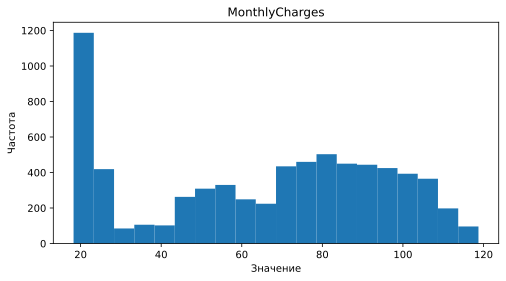


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение количественных дискретных величин

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Уникальные значения категориальных признаков

BeginDate : <DatetimeArray>
['2020-01-01 00:00:00', '2017-04-01 00:00:00', '2019-10-01 00:00:00',
 '2016-05-01 00:00:00', '2019-09-01 00:00:00', '2019-03-01 00:00:00',
 '2018-04-01 00:00:00', '2019-04-01 00:00:00', '2017-07-01 00:00:00',
 '2014-12-01 00:00:00', '2019-01-01 00:00:00', '2018-10-01 00:00:00',
 '2015-04-01 00:00:00', '2015-09-01 00:00:00', '2018-01-01 00:00:00',
 '2014-05-01 00:00:00', '2015-10-01 00:00:00', '2014-03-01 00:00:00',
 '2018-05-01 00:00:00', '2019-11-01 00:00:00', '2019-02-01 00:00:00',
 '2016-01-01 00:00:00', '2017-08-01 00:00:00', '2015-12-01 00:00:00',
 '2014-02-01 00:00:00', '2018-06-01 00:00:00', '2019-12-01 00:00:00',
 '2017-11-01 00:00:00', '2019-06-01 00:00:

In [8]:
review(contract, num_col_names_cont=['MonthlyCharges'])

### Датасет `personal` с данными о клиентах

In [9]:
review(personal)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение значений


,SeniorCitizen
count,"7,043.000"
mean,0.162
std,0.369
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Обзор


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Количество явных дубликатов: 7027

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Пропуски


gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение количественных непрерывных величин

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение количественных дискретных величин

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Уникальные значения категориальных признаков

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']


### Датасет `net` с данными об интернет-услугах

In [10]:
review(net)

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение значений


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Обзор


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Количество явных дубликатов: 5389

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Пропуски


InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение количественных непрерывных величин

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение количественных дискретных величин

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Уникальные значения категориальных признаков

InternetService : ['DSL' 'Fiber optic']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']


### Датасет `phone` с данными о телефонии

In [11]:
review(phone)

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение значений


,MultipleLines
count,6361
unique,2
top,No
freq,3390



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Обзор


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No



-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Количество явных дубликатов: 6359

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Пропуски


MultipleLines    0
dtype: int64


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение количественных непрерывных величин

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Распределение количественных дискретных величин

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Уникальные значения категориальных признаков

MultipleLines : ['No' 'Yes']


**ВЫВОД ПО РАЗДЕЛУ "ИЗУЧЕНИЕ ОБЩЕЙ ИНФОРМАЦИИ":**

Загружены 4 датафрейма: contract, personal, net, phone

С целью последующей предобработки выявлено:


**Датасет `contract`**

- Привести названия столбцов и значения категориальных признаков к "змеиному" типу.

- В колонке `EndDate` присутствует значение `No` — оно не является датой, поэтому pandas не смог корректно распарсить весь столбец. Необходимо заменить это значение на `NaT`, затем заменить тип данных столбца на `datetime`.

- В колонке `TotalCharges` неверный тип данных `object`. Заменить на тип данных `float`.

- Количество явных дубликатов возникло из-за того, что индексом стали id клиентов, необходимо удостовериться, что нет одинаковых индексов

**Датасет `personal`**

- Привести названия столбцов и значения категориальных признаков к "змеиному" типу.

- Бинаризовать категориальные признаки в столбцах `Partner` и `Dependents`, Yes/No → 1/0, а также `gender` Male/Female → 1/0

- Также необходимо удостовериться, что нет одинаковых индексов

**Датасет `internet`**

- Привести названия столбцов и значения категориальных признаков к "змеиному" типу.

- Бинаризовать категориальные признаки во всех столбцах, кроме вида интернет-соединения, Yes/No → 1/0

- Также необходимо удостовериться, что нет одинаковых индексов

**Датасет `phone`**

- Бинаризовать категориальный признак `MultipleLines`, Yes/No → 1/0

- Также необходимо удостовериться, что нет одинаковых индексов

## Предобработка данных

### Приведение названий столбцов и значений в столбцах к "змеиному" типу

In [12]:
# Преобразование названий колонок и значений столбцов

# Словарь с датафреймами
dfs = {
    'contract': contract,
    'personal': personal,
    'net': net,
    'phone': phone
}

# Преобразование колонок и значений
for name, df in dfs.items():
    df = to_snake_case_columns(df)
    df = to_snake_case_categories(df, df.select_dtypes(include='object').columns)
    dfs[name] = df  

In [13]:
contract.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
7590-VHVEG,2020-01-01,no,month-to-month,yes,electronic_check,29.850,31.04
5575-GNVDE,2017-04-01,no,one_year,no,mailed_check,56.950,2071.84
3668-QPYBK,2019-10-01,no,month-to-month,yes,mailed_check,53.850,226.17
7795-CFOCW,2016-05-01,no,one_year,no,bank_transfer_(automatic),42.300,1960.6
9237-HQITU,2019-09-01,no,month-to-month,yes,electronic_check,70.700,353.5


In [14]:
personal.head()

,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,female,0,yes,no
5575-GNVDE,male,0,no,no
3668-QPYBK,male,0,no,no
7795-CFOCW,male,0,no,no
9237-HQITU,female,0,no,no


In [15]:
net.head()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
customerID,,,,,,,
7590-VHVEG,dsl,no,yes,no,no,no,no
5575-GNVDE,dsl,yes,no,yes,no,no,no
3668-QPYBK,dsl,yes,yes,no,no,no,no
7795-CFOCW,dsl,yes,no,yes,yes,no,no
9237-HQITU,fiber_optic,no,no,no,no,no,no


In [16]:
phone.head()

,multiple_lines
customerID,
5575-GNVDE,no
3668-QPYBK,no
9237-HQITU,no
9305-CDSKC,yes
1452-KIOVK,yes


### Индексы

In [17]:
# проверим нет ли одинаковых индексов в датафреймах

for name, df in dfs.items():
    if df.index.is_unique:
        print(f"✅ Индексы уникальны в '{name}'")
    else:
        duplicates = df.index[df.index.duplicated()].unique()
        print(f"❗ Найдены дублирующиеся индексы в '{name}': {list(duplicates)}")

✅ Индексы уникальны в 'contract'
✅ Индексы уникальны в 'personal'
✅ Индексы уникальны в 'net'
✅ Индексы уникальны в 'phone'


### Датафрейм `contract`

In [18]:
# в столбце end_date заменим значение `no` на NaT, затем заменим тип данных столбца на datetime

contract['end_date'] = pd.to_datetime(contract['end_date'].replace('no', pd.NaT))

In [19]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 698.2+ KB


In [20]:
# Преобразуем total_charges в float, некорректные значения станут NaN

contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

# Посмотрим строки, где total_charges стал NaN

nan_rows = contract[contract['total_charges'].isna()]
display("Строки с некорректным total_charges:", nan_rows)

'Строки с некорректным total_charges:'

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,NaT,two_year,yes,bank_transfer_(automatic),52.550,NaN
3115-CZMZD,2020-02-01,NaT,two_year,no,mailed_check,20.250,NaN
5709-LVOEQ,2020-02-01,NaT,two_year,no,mailed_check,80.850,NaN
4367-NUYAO,2020-02-01,NaT,two_year,no,mailed_check,25.750,NaN
1371-DWPAZ,2020-02-01,NaT,two_year,no,credit_card_(automatic),56.050,NaN
7644-OMVMY,2020-02-01,NaT,two_year,no,mailed_check,19.850,NaN
3213-VVOLG,2020-02-01,NaT,two_year,no,mailed_check,25.350,NaN
2520-SGTTA,2020-02-01,NaT,two_year,no,mailed_check,20.000,NaN
2923-ARZLG,2020-02-01,NaT,one_year,yes,mailed_check,19.700,NaN


По условию, данные у нас по состоянию на 1 февраля 2020 года. Значит, значения Nan возникли из-за того, что столбец `total_charges` не успел сформироваться, потому что это новые клиенты, которые первый раз оплатили услуги. Заполним этот столбец значениями из `monthly_charges`

In [21]:
# Заменим NaN в total_charges значениями из monthly_charges

contract['total_charges'] = contract['total_charges'].fillna(contract['monthly_charges'])

In [22]:
display("Осталось пропущенных значений:", contract['total_charges'].isna().sum())

'Осталось пропущенных значений:'

0

In [23]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 698.2+ KB


### Бинаризация признаков Yes/No → 1/0

In [24]:
# Бинаризация признаков со значениями 'yes'/'no'

for name, df in dfs.items():
    for col in df.select_dtypes(include='object').columns:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals) <= {'yes', 'no'}:
            df[col] = df[col].map({'yes': 1, 'no': 0})
            print(f"🔄 Преобразован столбец '{col}' в '{name}' (yes/no → 1/0)")

🔄 Преобразован столбец 'paperless_billing' в 'contract' (yes/no → 1/0)
🔄 Преобразован столбец 'partner' в 'personal' (yes/no → 1/0)
🔄 Преобразован столбец 'dependents' в 'personal' (yes/no → 1/0)
🔄 Преобразован столбец 'online_security' в 'net' (yes/no → 1/0)
🔄 Преобразован столбец 'online_backup' в 'net' (yes/no → 1/0)
🔄 Преобразован столбец 'device_protection' в 'net' (yes/no → 1/0)
🔄 Преобразован столбец 'tech_support' в 'net' (yes/no → 1/0)
🔄 Преобразован столбец 'streaming_t_v' в 'net' (yes/no → 1/0)
🔄 Преобразован столбец 'streaming_movies' в 'net' (yes/no → 1/0)
🔄 Преобразован столбец 'multiple_lines' в 'phone' (yes/no → 1/0)


In [25]:
# также закодируем признак `gender`

personal['gender'] = personal['gender'].map({'male': 1, 'female': 0})

In [26]:
# проверим датафреймы

contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   int64         
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 698.2+ KB


In [27]:
# проверим датафреймы

personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   gender          7043 non-null   int64
 1   senior_citizen  7043 non-null   int64
 2   partner         7043 non-null   int64
 3   dependents      7043 non-null   int64
dtypes: int64(4)
memory usage: 533.2+ KB


In [28]:
# проверим датафреймы

net.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   int64 
 2   online_backup      5517 non-null   int64 
 3   device_protection  5517 non-null   int64 
 4   tech_support       5517 non-null   int64 
 5   streaming_t_v      5517 non-null   int64 
 6   streaming_movies   5517 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 473.9+ KB


In [29]:
# проверим датафреймы

phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   multiple_lines  6361 non-null   int64
dtypes: int64(1)
memory usage: 357.4+ KB


**ВЫВОД ПО РАЗДЕЛУ "ПРЕДОБРАБОТКА ДАННЫХ":**
  
- Названия всех столбцов и строковых признаков приведены к `snake_case`

- Бинаризация признаков. Признаки со значениями `yes`/`no` приведены к 1/0 с автоматическим определением. Признак `gender` закодирован явно: `male` → 1, `female` → 0

- Обработка числовых данных. Признак `total_charges` преобразован в `float`, пропущенные значения `NaN` заменены соответствующими значениями из `monthly_charges`

- Проверена уникальность индексов внутри каждого датафрейма. Все проверки прошли успешно: дубликатов нет

Можно приступить к объединению датафреймов в один для удобства проведения EDA и последующего формирования матрицы признаков для модели.


## Объединение данных

Так как у нас все датафреймы с индексами - id клиентов, можем объединить последовательно при помощи `.join`

In [30]:
# Объединение датафреймов в один

df = contract.join(personal, how='left')
df = df.join(net, how='left')
df = df.join(phone, how='left')

In [31]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,month-to-month,1,electronic_check,29.850,31.040,0,0,1,0,dsl,0.000,1.000,0.000,0.000,0.000,0.000,NaN
5575-GNVDE,2017-04-01,NaT,one_year,0,mailed_check,56.950,"2,071.840",1,0,0,0,dsl,1.000,0.000,1.000,0.000,0.000,0.000,0.000
3668-QPYBK,2019-10-01,NaT,month-to-month,1,mailed_check,53.850,226.170,1,0,0,0,dsl,1.000,1.000,0.000,0.000,0.000,0.000,0.000
7795-CFOCW,2016-05-01,NaT,one_year,0,bank_transfer_(automatic),42.300,"1,960.600",1,0,0,0,dsl,1.000,0.000,1.000,1.000,0.000,0.000,NaN
9237-HQITU,2019-09-01,NaT,month-to-month,1,electronic_check,70.700,353.500,0,0,0,0,fiber_optic,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   int64         
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   int64         
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   int64         
 10  dependents         7043 non-null   int64         
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   float64       
 13  online_backup      5517 non-null   float64       
 14

Появилось много пропусков, это связано с тем, что в датафреймах по услугам интернета и телефонии нет данных по клиентам, которые не пользуются этими услугами. Поэтому можно заполнить пропуски заглушкой `-1`, кроме столбца `internet_service`- заменим на строковое значение `no_internet`

In [33]:
# Заполняем все пропуски в интернет-признаках значением 0

cols_net = ['online_security', 'online_backup', 'device_protection',
            'tech_support', 'streaming_t_v', 'streaming_movies']

df[cols_net] = df[cols_net].fillna(-1)

# Аналогично для телефонной линии

df['multiple_lines'] = df['multiple_lines'].fillna(-1)

# Пропуски в internet_service заменяем на строку 'no_internet' (нет интернета)

df['internet_service'] = df['internet_service'].fillna('no_internet')

In [34]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,month-to-month,1,electronic_check,29.850,31.040,0,0,1,0,dsl,0.000,1.000,0.000,0.000,0.000,0.000,-1.000
5575-GNVDE,2017-04-01,NaT,one_year,0,mailed_check,56.950,"2,071.840",1,0,0,0,dsl,1.000,0.000,1.000,0.000,0.000,0.000,0.000
3668-QPYBK,2019-10-01,NaT,month-to-month,1,mailed_check,53.850,226.170,1,0,0,0,dsl,1.000,1.000,0.000,0.000,0.000,0.000,0.000
7795-CFOCW,2016-05-01,NaT,one_year,0,bank_transfer_(automatic),42.300,"1,960.600",1,0,0,0,dsl,1.000,0.000,1.000,1.000,0.000,0.000,-1.000
9237-HQITU,2019-09-01,NaT,month-to-month,1,electronic_check,70.700,353.500,0,0,0,0,fiber_optic,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [35]:
# Проверка — вывод количества оставшихся пропусков

df.isna().sum()

begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_t_v           0
streaming_movies        0
multiple_lines          0
dtype: int64

Остались пропуски в столбце `end_date`, так как это расторжение договора - это наш целевой признак. Создадим столбец с признаком оттока `churn`

In [36]:
# Создадим бинарный признак `churn`

df['churn'] = df['end_date'].notna().astype(int)

In [37]:
# Заменим пропуски в столбце `end_date` датой сбора датасета 1 февраля 2020

df['end_date'] = df['end_date'].fillna(pd.Timestamp("2020-02-01"))

In [38]:
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,month-to-month,1,electronic_check,29.850,31.040,0,0,1,0,dsl,0.000,1.000,0.000,0.000,0.000,0.000,-1.000,0
5575-GNVDE,2017-04-01,2020-02-01,one_year,0,mailed_check,56.950,"2,071.840",1,0,0,0,dsl,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0
3668-QPYBK,2019-10-01,2020-02-01,month-to-month,1,mailed_check,53.850,226.170,1,0,0,0,dsl,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0
7795-CFOCW,2016-05-01,2020-02-01,one_year,0,bank_transfer_(automatic),42.300,"1,960.600",1,0,0,0,dsl,1.000,0.000,1.000,1.000,0.000,0.000,-1.000,0
9237-HQITU,2019-09-01,2020-02-01,month-to-month,1,electronic_check,70.700,353.500,0,0,0,0,fiber_optic,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   int64         
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   int64         
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   int64         
 10  dependents         7043 non-null   int64         
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   float64       
 13  online_backup      7043 non-null   float64       
 14

**ВЫВОД ПО РАЗДЕЛУ "ОБЪЕДИНЕНИЕ ДАННЫХ":**
  
- Объединены 4 таблицы: `contract`, `personal`, `net`, `phone`. Объединение выполнено по индексу `customer_id` с использованием `join`. Итоговый датафрейм `df` содержит 7043 строки и 19 столбцов

- Интернет-признаки (`online_security`, `tech_support`, `streaming_t_v`, и др.). Были пропуски у клиентов без интернета. Пропуски заменены на `-1` — интерпретируются как "услуга не подключена"

- Телефонный признак `multiple_lines`. Пропуски заменены на `-1` — интерпретируются как "не пользуются услугами телефонии"

- В столбце `internet_service` пропущенные значения заменены на `no_internet`, что означает "отсутствует интернет"

- пропуски в колонке `end_date` заменены на дату сбора датасета 1 февраля 2020

- Создание целевого признака `churn`.


## Исследовательский анализ

Итак, мы имеем датафрейм из 7043 строк (7043 клиента), и 19 столбцов. Один из них - дата начала обслуживания, количественных непрерывных признаков 2: `monthly_charges` и `total_charges`. Категориальных признаков 15. И целевой признак оттока - `churn` 

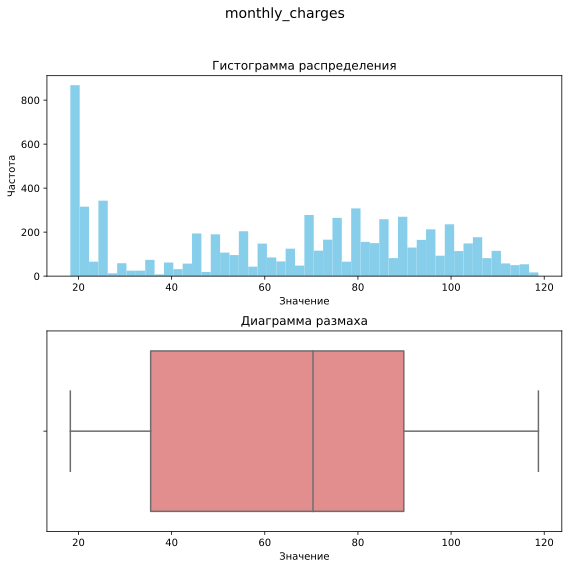

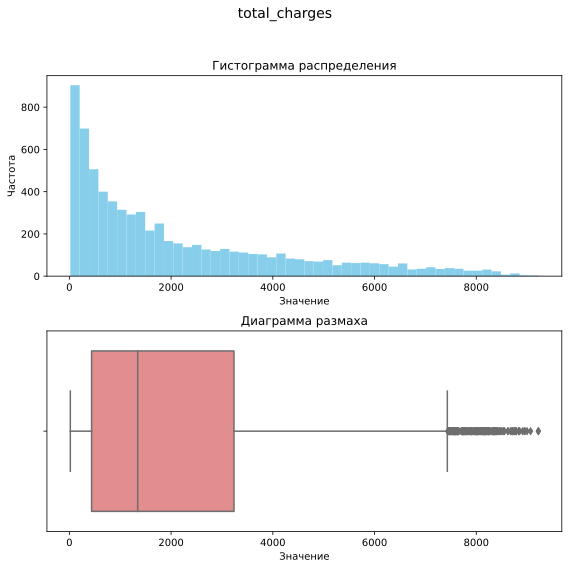

,monthly_charges,total_charges
count,"7,043.000","7,043.000"
mean,64.762,"2,115.378"
std,30.090,"2,112.679"
min,18.250,19.050
25%,35.500,436.750
50%,70.350,"1,343.350"
75%,89.850,"3,236.690"
max,118.750,"9,221.380"


In [40]:
# Изучим распределение количественных непрерывных признаков

df_num_col_cont = ['monthly_charges', 'total_charges']

for c in df_num_col_cont:
    plt.figure(figsize=(8, 8))
    plt.suptitle(c, fontsize=14)

    # Верхний subplot — гистограмма
    plt.subplot(2, 1, 1)
    df[c].plot(kind='hist', bins=50, title='Гистограмма распределения', color='skyblue')
    plt.xlabel('Значение')
    plt.ylabel('Частота')

    # Нижний subplot — boxplot
    plt.subplot(2, 1, 2)
    sns.boxplot(x=df[c], color='lightcoral')
    plt.title('Диаграмма размаха')
    plt.xlabel('Значение')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()
  

df[df_num_col_cont].describe()

Ежемесячные расходы распределены неравномерно, больше сдвинуты влево, что указывает на большое количество клиентов с малым ежемесячным платежом. Минимальный - 18, максимум - 118, медиана - 70.
Общие расходы - распределение смещено влево - в большинстве клиенты с небольшими общими расходами

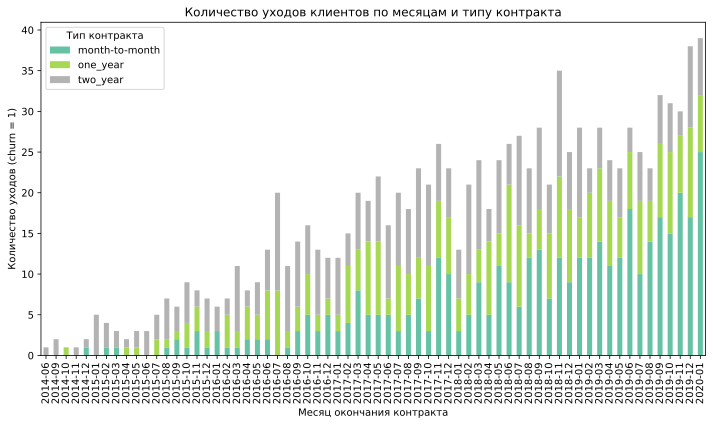

In [41]:
# Распределение столбца с датой расторжения договора

# Фильтруем ушедших клиентов с указанной датой окончания
churned = df[df['churn'] == 1].copy()
churned['end_month'] = churned['end_date'].dt.to_period('M').astype(str)

# Группировка по месяцу и типу контракта
churn_by_month_type = (
    churned.groupby(['end_month', 'type'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Визуализация: stacked bar chart
churn_by_month_type.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='Set2'
)

plt.title('Количество уходов клиентов по месяцам и типу контракта')
plt.xlabel('Месяц окончания контракта')
plt.ylabel('Количество уходов (churn = 1)')
plt.xticks(rotation=90)
plt.legend(title='Тип контракта')
plt.tight_layout()
plt.show()


По графику не прослеживается какой-то явной зависимости ухода клиента от месяца расторжения договора. Растущий тренд оттока клиентов, а также наблюдается растущий тренд ухода доли клиентов с помесячной оплатой начиная с 2018 года.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

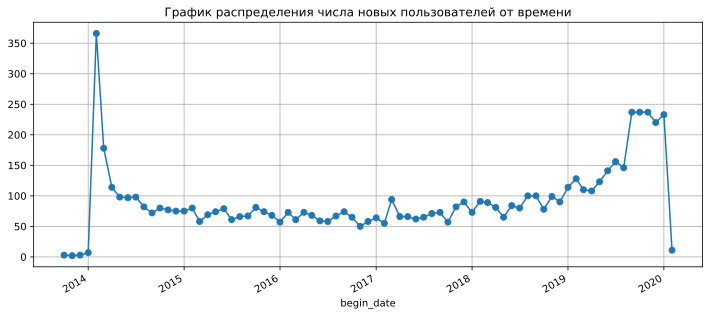

In [42]:
# Распределение столбца с датой заключения договора

df['begin_date'].value_counts().plot(style='o-', grid=True,figsize=(12, 5))
plt.title("График распределения числа новых пользователей от времени")
plt.show()


Наблюдается всплеск количества новых клиентов в первом полугодии 2014 года. Скорее всего это связано с масштабной рекламной кампанией или промоакциями с целью привлечения пользователей. Затем после спада наблюдается равномерный практически неизменный тренд с ростом после середины 2018 года.

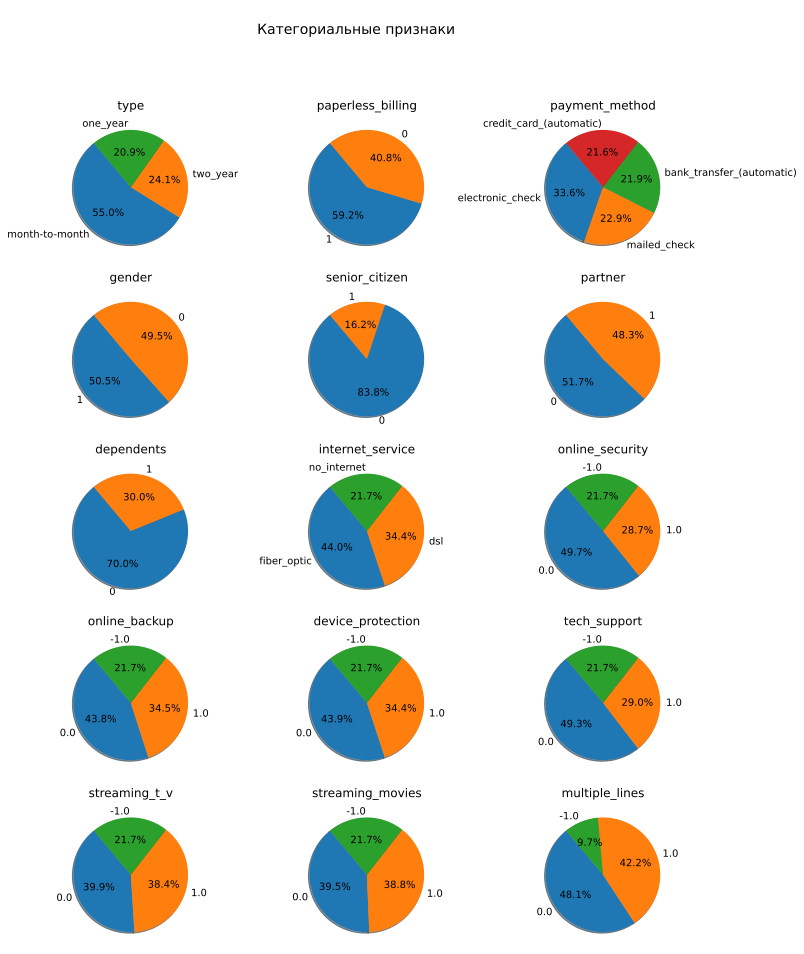

In [43]:
# Анализ категориальных признаков

df_cat_col = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
              'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
             'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']
fig = plt.figure(figsize=(12, 15))
fig.suptitle('\n' + 'Категориальные признаки', fontsize=14)

for i in range(len(df_cat_col)):
    plt.subplot(5, 3, i+1)
    df[df_cat_col[i]].value_counts().plot.pie(
        autopct='%1.1f%%', startangle=130, ylabel='', shadow=True)
    plt.title(df_cat_col[i])

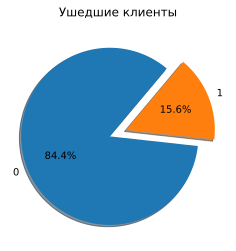

In [44]:
# распределение целевого признака

df['churn'].value_counts().plot.pie(
        autopct='%1.1f%%', startangle=50, ylabel='', shadow=True, explode=[0.1, 0.1])
plt.title("Ушедшие клиенты");

**Предварительный вывод по исследовательскому анализу датасета**

- `monthly_charges` ежемесячные расходы распределены неравномерно, больше сдвинуты влево, что указывает на большое количество клиентов с малым ежемесячным платежом. Минимальный - 18, максимум - 118, медиана - 70

- `total_charges` общие расходы - распределение смещено влево - в большинстве клиенты с небольшими общими расходами

- не прослеживается какой-то явной зависимости ухода клиента от месяца расторжения договора. Растущий тренд оттока клиентов, а также наблюдается растущий тренд ухода доли клиентов с помесячной оплатой начиная с 2018 года.

- всплеск количества новых клиентов в первом полугодии 2014 года. Скорее всего это связано с масштабной рекламной кампанией или промоакциями с целью привлечения пользователей. Затем после спада наблюдается равномерный практически неизменный тренд с ростом после середины 2018 года.

- половина клиентов с типом договора "помесячный"

- больше половины получает электронный чек

- в основном оплата осуществляется через электронный чек (через сайт/интернет). Остальные виды оплаты практически поровну распределились между бумажным чеком, отправленным по почте, автоматическим переводом с банковского счёта и автосписанием с банковской карты.

- по половому признаку и наличию супруга/супруги клиенты распределены поровну

- 16% клиентов составляют пенсионеры

- 30% клиентов имеют детей

- 22% клиентов не пользуются интернет-услугами, а среди тех, кто пользуется - больше предпочитают оптоволоконную технологию

- большая часть клиентов, которые пользуются интернет-услугами не пользуются дополнительными услугами по блокировке опасных сайтов, облачным хранилищем, антивирусом и выделенной линией технической поддержки

- пользование услугами онлайн ТВ и каталогом фильмов распределилось поровну: половина пользуется, половина нет

- почти 10% не пользуются услугами телефонии, а из тех кто пользуется - большинство не используют услуги второй линии

- целевой признак несбалансирован, что свойственно задаче оттока: ушедших клиентов 15,6%.

<h3> Портрет ушедшего клиента<a class="tocSkip"> </h3>

Для того, чтобы составить портрет ушедшего клиента, визуализируем данные по сегменту `churn` - характеристики ушедших в сравнении с оставшимися.

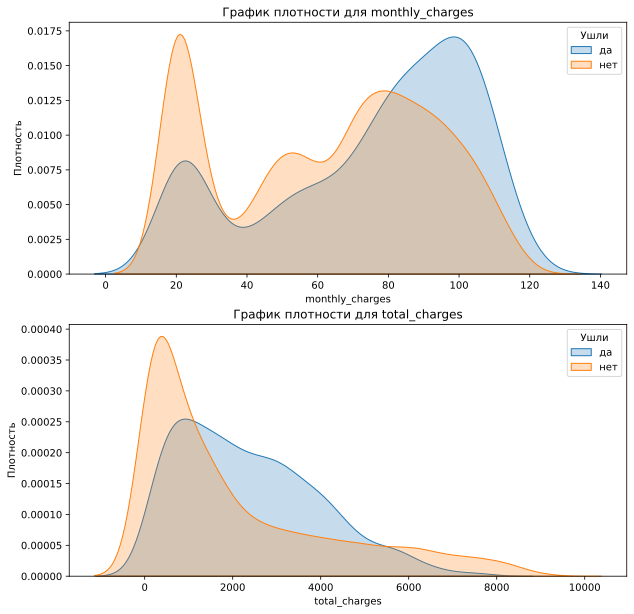

In [45]:
# Визуализируем распределение плотности значений по ушедшим и активным клиентам

fig = plt.figure(figsize=(10, 10))

for i in range(len(df_num_col_cont)):
    plt.subplot(len(df_num_col_cont), 1, i+1)
    sns.kdeplot(df.query('churn==1')[df_num_col_cont[i]], shade=True, label='да')
    sns.kdeplot(df.query('churn==0')[df_num_col_cont[i]], shade=True, label='нет')
    plt.title(f'График плотности для {df_num_col_cont[i]}')
    plt.xlabel(df_num_col_cont[i])
    plt.ylabel("Плотность")
    plt.legend(title="Ушли");

Среди ушедших клиентов те, кто платили более высокие ежемесячные платежи.
По совокупным платежам ушли клиенты со средними общими расходами.

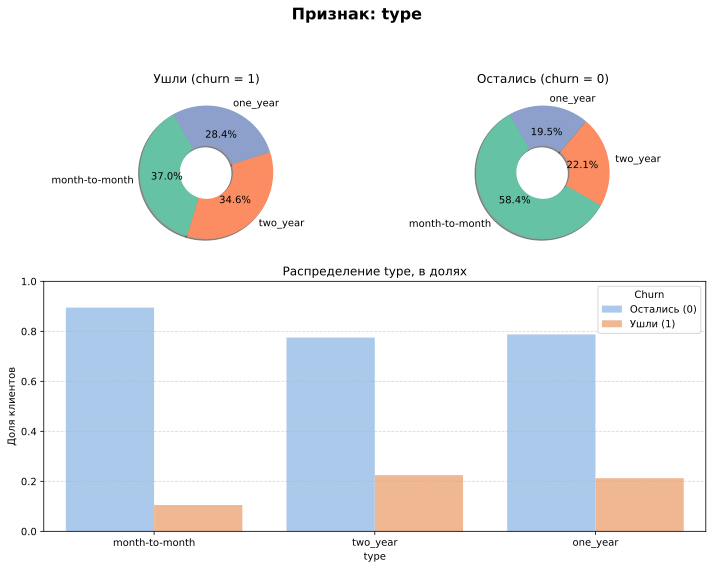

In [46]:
# распределение признака оттока по категориальному признаку "тип подписки"

draw_combined_plots_relative(df, 'type')

примерно одинаковые доли ушедших в разрезе по видам подписок (помесячно, 1 год или 2 года), что не должно быть так, поскольку среди оставшихся доля клиентов с долгосрочной подпиской составляет 42%, а среди ушедших доля таких клиентов больше 60%. Это потеря прибыльных клиентов с долгосрочной подпиской.

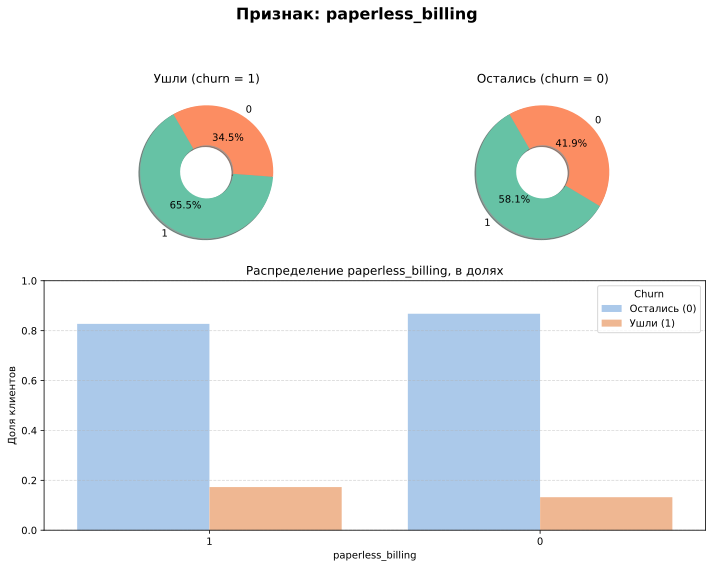

In [47]:
# распределение признака оттока по категориальному признаку "электронный чек"

draw_combined_plots_relative(df, 'paperless_billing')

Чуть больше уходит клиентов, пользующихся электронным чеком.

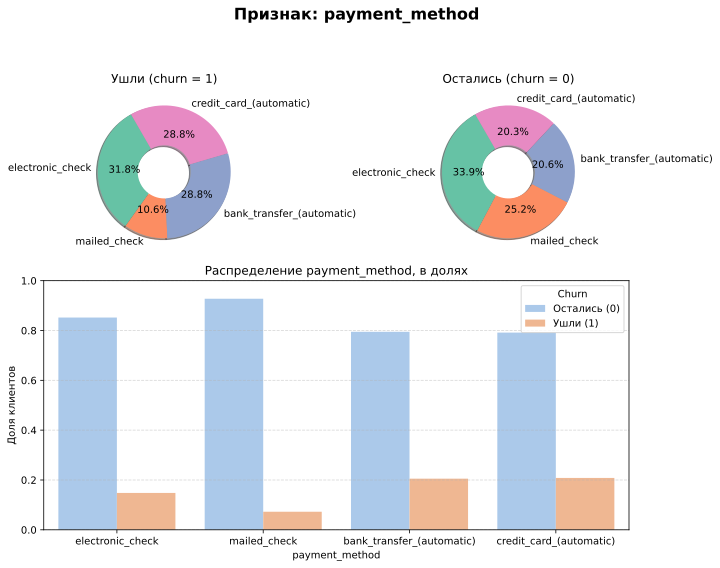

In [48]:
# распределение признака оттока по категориальному признаку "тип оплаты"

draw_combined_plots_relative(df, 'payment_method')

Доля ушедших клиентов с автосписаниями больше, чем с другими способами оплаты

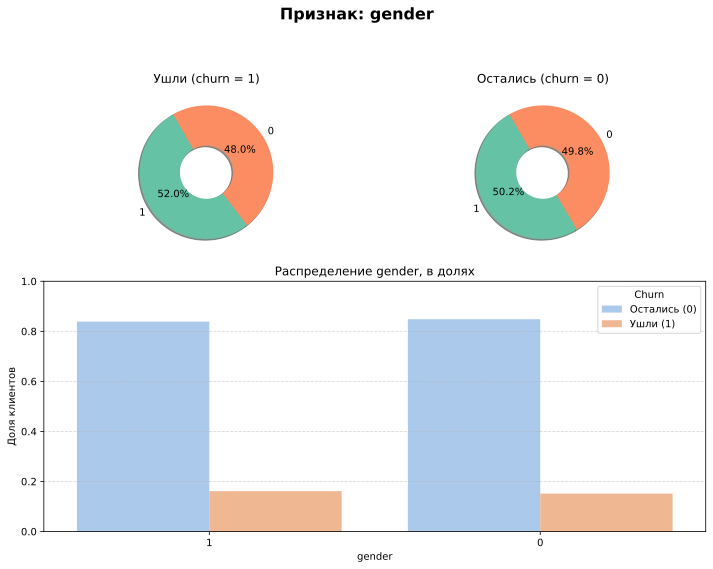

In [49]:
# распределение признака оттока по категориальному признаку "пол"

draw_combined_plots_relative(df, 'gender')

Нет явной зависимости

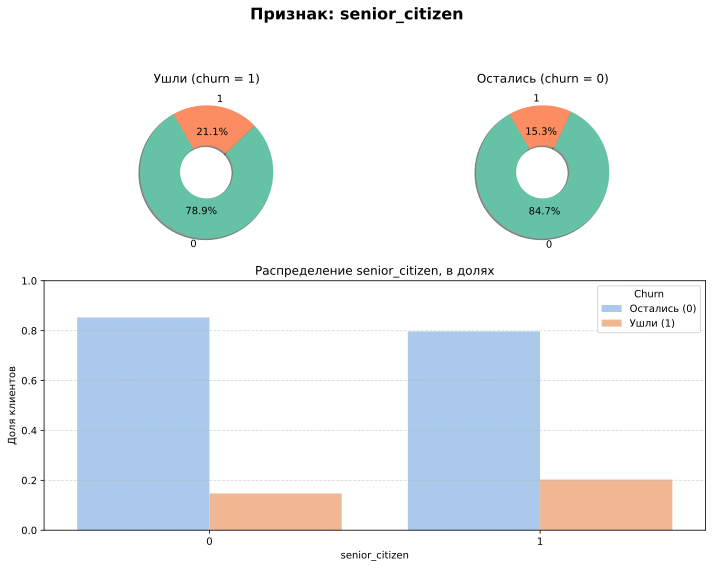

In [50]:
# распределение признака оттока по категориальному признаку "пенсионер"

draw_combined_plots_relative(df, 'senior_citizen')

Чуть больше доля пенсионеров среди ушедших клиентов

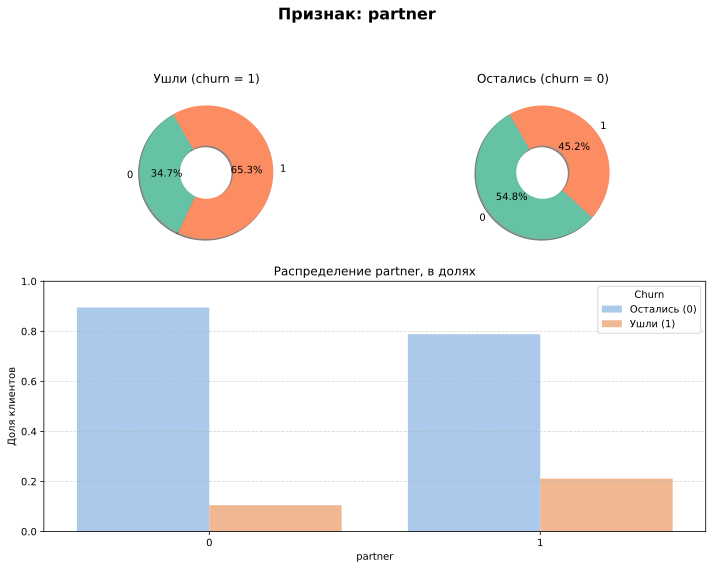

In [51]:
# распределение признака оттока по категориальному признаку "партнер"

draw_combined_plots_relative(df, 'partner')

Больше ушло женатых/замужних клиентов.

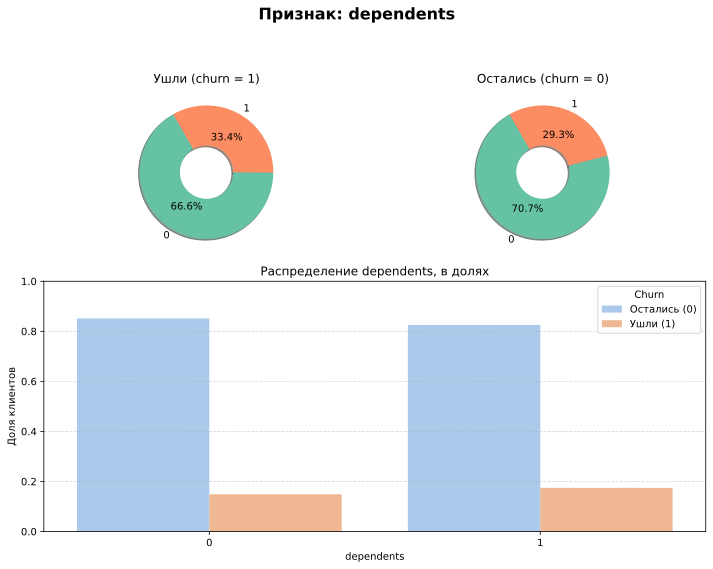

In [52]:
# распределение признака оттока по категориальному признаку "дети"

draw_combined_plots_relative(df, 'dependents')

Практически нет зависимости ухода от наличия детей

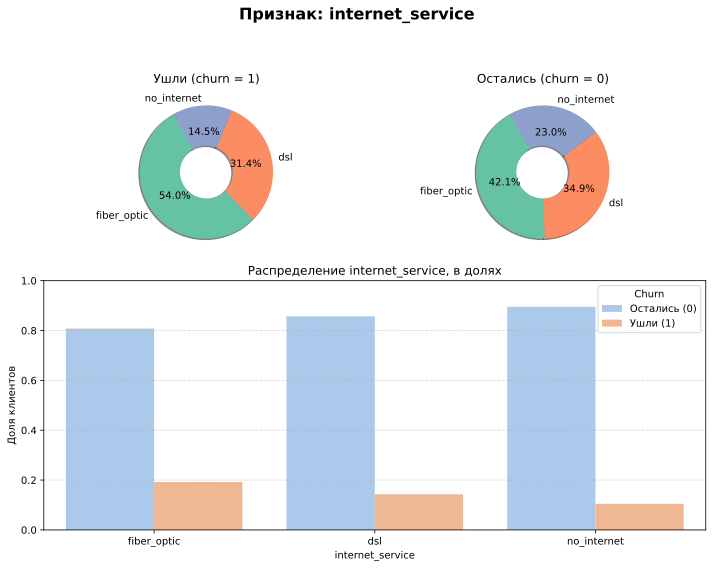

In [53]:
# распределение признака оттока по категориальному признаку "интернет-сервис"

draw_combined_plots_relative(df, 'internet_service')

Больше ушло клиентов, пользующихся оптоволокном. Возможно есть какие-то технические неполадки или сложности?

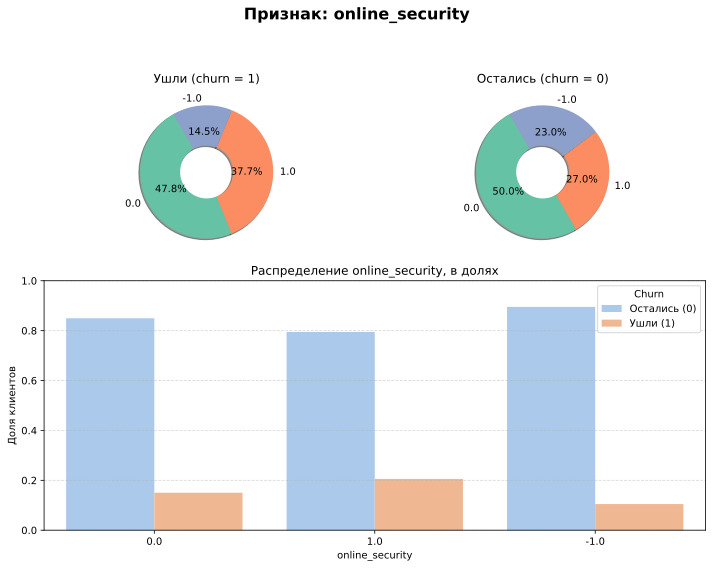

In [54]:
# распределение признака оттока по категориальному признаку "блокировка опасных сайтов"

draw_combined_plots_relative(df, 'online_security')

Чуть больше доля тех, кто пользовался услугой

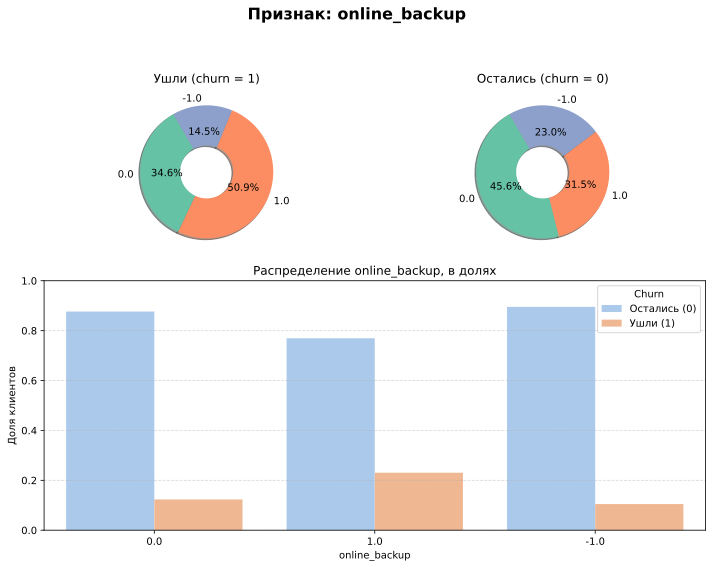

In [55]:
# распределение признака оттока по категориальному признаку "облачное хранилище"

draw_combined_plots_relative(df, 'online_backup')

Та же самая картина

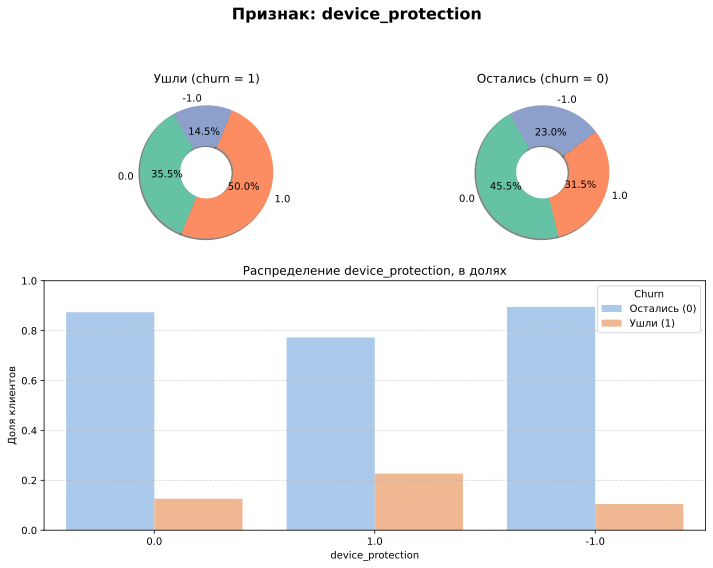

In [56]:
# распределение признака оттока по категориальному признаку "антивирус"

draw_combined_plots_relative(df, 'device_protection')

И здесь

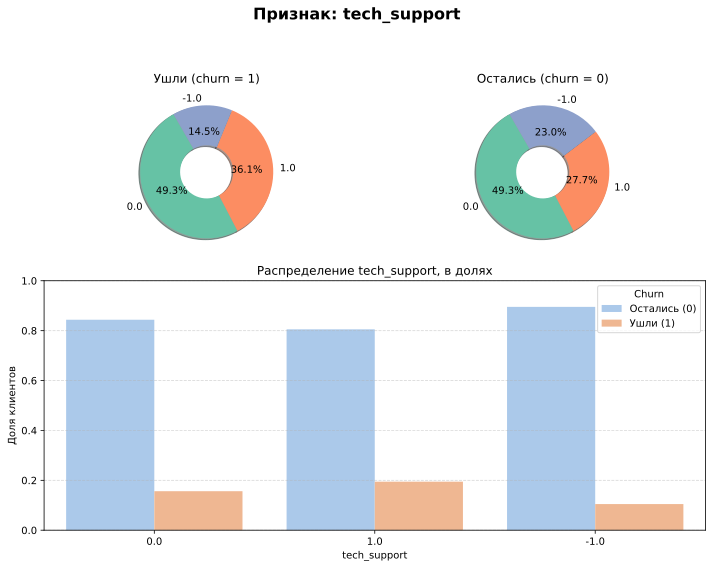

In [57]:
# распределение признака оттока по категориальному признаку "техническая поддержка"

draw_combined_plots_relative(df, 'tech_support')

Здесь также

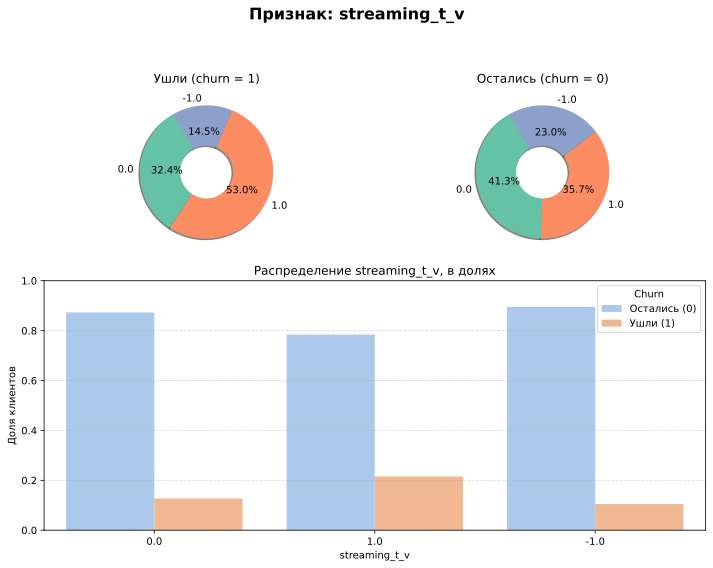

In [58]:
# распределение признака оттока по категориальному признаку "стримминговое ТВ"

draw_combined_plots_relative(df, 'streaming_t_v')

Также

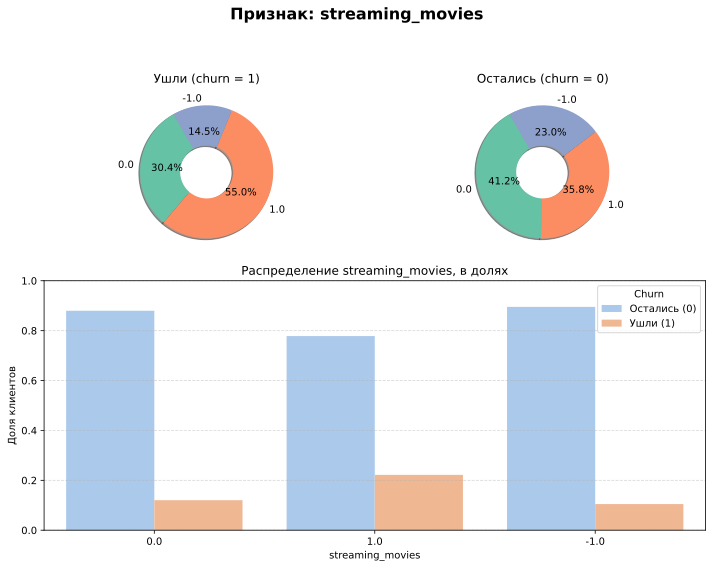

In [59]:
# распределение признака оттока по категориальному признаку "каталог фильмов"

draw_combined_plots_relative(df, 'streaming_movies')

Также

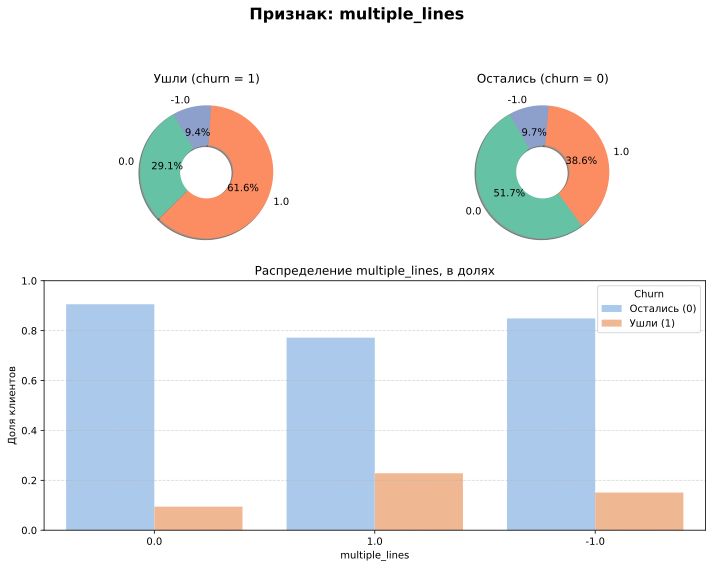

In [60]:
# распределение признака оттока по категориальному признаку "вторая выделенная линия телефонии"

draw_combined_plots_relative(df, 'multiple_lines')

И здесь

**Портрет ушедшего клиента:**

- платил более высокий ежемесячный платеж

- по совокупным платежам ушли клиенты со средними общими расходами.

- примерно одинаковые доли ушедших в разрезе по видам подписок (помесячно, 1 год или 2 года), что не должно быть так, поскольку среди оставшихся доля клиентов с долгосрочной подпиской составляет 42%, когда среди ушедших доля таких клиентов больше 60%. Это потеря лояльных клиентов.

- доля ушедших клиентов, использующих электронный чек и автосписание с карты и банковского счета, больше. 

- небольшое отличие в долях пенсионеров: среди ушедших их больше

- уходит больше клиентов, имеющих партнера, наличие детей не влияет на уход клиента.

- среди ушедших больше тех, кто пользовался доп интернет-услугами: блокировкой опасных сайтов, облачным хранилищем, антивирусом и выделенной линией технической поддержки, сервисами ТВ и фильмов.

- среди ушедших больше тех, кто пользовался услугами второй линии сервиса телефонии

## Выделение новых признаков

Попробуем выделить следующие признаки:

- длительность договора в днях

- сегменты: кто пользуется только интернетом, только телефонией и обеими типами услуг

- количество подключенных услуг

In [61]:
# Длительность договора в днях
# сначала пропуски заполним нашей конечной датой 1 февраля 2020

df['duration_days'] = (df['end_date'] - df['begin_date']).dt.days

In [63]:
# Сегмент клиента по типу подключения

def segment(row):
    internet = row['internet_service'] != 'no_internet'
    phone = row['multiple_lines'] != -1
    if internet and phone:
        return 'internet_and_phone'
    elif internet:
        return 'internet_only'
    elif phone:
        return 'phone_only'
    else:
        return 'no_services'

df['service_segment'] = df.apply(segment, axis=1)

In [64]:
# Посмотрим распределение сегментов

df['service_segment'].value_counts()

service_segment
internet_and_phone    4835
phone_only            1526
internet_only          682
Name: count, dtype: int64

In [65]:
# Общее количество подключённых услуг

# Так как в столбце "multiple_lines" есть заглушка -1, то создадим другой столбец: 
# есть ли телефония (будет 1) и доп услуга второй линии (будет 2)

df['phone_services'] = (df['multiple_lines'] + 1).astype(int)


service_cols = [
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_t_v', 'streaming_movies', 'phone_services'
]
df['num_services'] = df[service_cols].sum(axis=1)

In [66]:
df.head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,churn,duration_days,service_segment,phone_services,num_services
customerID,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,month-to-month,1,electronic_check,29.850,31.040,0,0,1,0,dsl,0.000,1.000,0.000,0.000,0.000,0.000,-1.000,0,31,internet_only,0,1.000
5575-GNVDE,2017-04-01,2020-02-01,one_year,0,mailed_check,56.950,"2,071.840",1,0,0,0,dsl,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0,1036,internet_and_phone,1,3.000
3668-QPYBK,2019-10-01,2020-02-01,month-to-month,1,mailed_check,53.850,226.170,1,0,0,0,dsl,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0,123,internet_and_phone,1,3.000
7795-CFOCW,2016-05-01,2020-02-01,one_year,0,bank_transfer_(automatic),42.300,"1,960.600",1,0,0,0,dsl,1.000,0.000,1.000,1.000,0.000,0.000,-1.000,0,1371,internet_only,0,3.000
9237-HQITU,2019-09-01,2020-02-01,month-to-month,1,electronic_check,70.700,353.500,0,0,0,0,fiber_optic,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,153,internet_and_phone,1,1.000
9305-CDSKC,2019-03-01,2020-02-01,month-to-month,1,electronic_check,99.650,"1,150.960",0,0,0,0,fiber_optic,0.000,0.000,1.000,0.000,1.000,1.000,1.000,0,337,internet_and_phone,2,5.000
1452-KIOVK,2018-04-01,2020-02-01,month-to-month,1,credit_card_(automatic),89.100,"2,058.210",1,0,0,1,fiber_optic,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0,671,internet_and_phone,2,4.000
6713-OKOMC,2019-04-01,2020-02-01,month-to-month,0,mailed_check,29.750,300.480,0,0,0,0,dsl,1.000,0.000,0.000,0.000,0.000,0.000,-1.000,0,306,internet_only,0,1.000
7892-POOKP,2017-07-01,2020-02-01,month-to-month,1,electronic_check,104.800,"3,573.680",0,0,1,0,fiber_optic,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0,945,internet_and_phone,2,6.000


## Корреляционный анализ

Обычная корреляция (например, Pearson) работает только с числовыми признаками и предполагает линейную связь между ними.
Но у нас в датасете много категориальных и бинарных признаков, где:

- признаки не числовые (например, contract_type, payment_method),

- возможна нелинейная и неочевидная зависимость,

- мы хотим увидеть, как такие признаки влияют на churn.

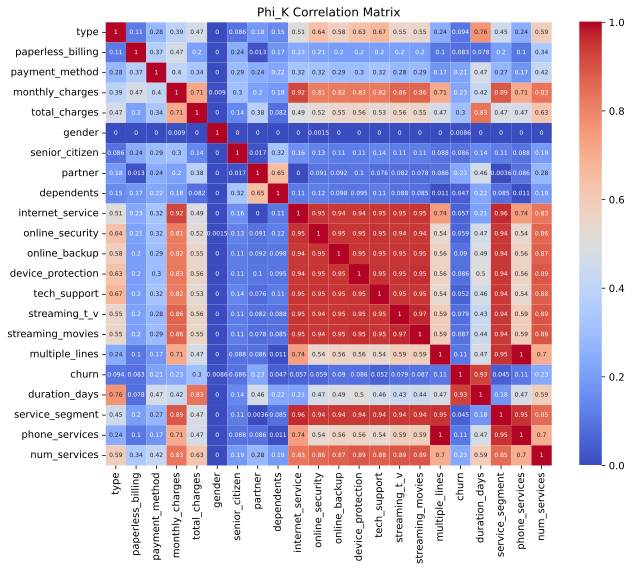

In [67]:
# Вычисление матрицы корреляции с использованием phik для датасета `df`

df_num_col_cont = ['monthly_charges', 'total_charges']
corr_matrix = df.drop(['begin_date', 'end_date'], axis=1).phik_matrix(df_num_col_cont)

# Визуализация матрицы корреляции

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.title('Phi_K Correlation Matrix')
plt.show()

Оценим силу связи по шкале Чеддока, где слабая — от 0,1 до 0,3; умеренная — от 0,3 до 0,5; заметная — от 0,5 до 0,7; высокая — от 0,7 до 0,9; весьма высокая (сильная) — от 0,9 до 1,0.

- Корреляция между допуслугами весьма высокая, уберем их матрицы признаков при обучении

Оставим следующие признаки, которые хорошо коррелируют с нашей целевой переменной:

- payment_method
- monthly_charges
- total_charges
- partner
- duration_days
- phone_services 
- num_services

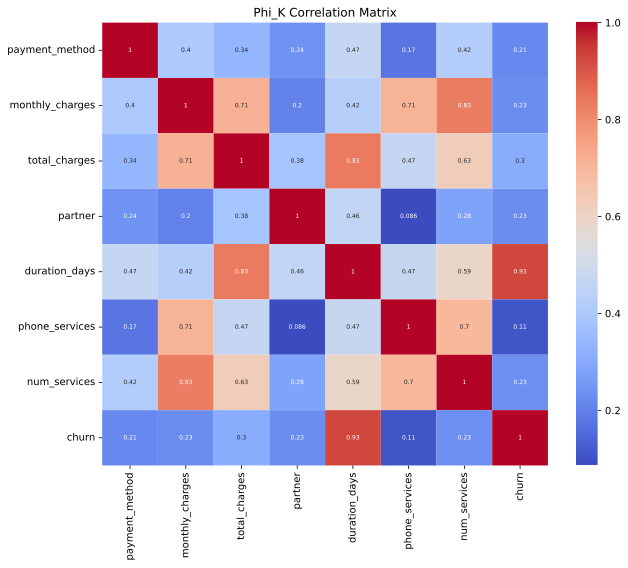

In [68]:
corr_matrix = df[['payment_method', 'monthly_charges', 'total_charges', 'partner',
                  'duration_days', 'phone_services', 'num_services', 'churn']].phik_matrix(df_num_col_cont)

# Визуализация матрицы корреляции

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.title('Phi_K Correlation Matrix')
plt.show()

## Подготовка данных к моделированию

Выполним подготовку данных.
Сначала создадим тренировочную и тестовую выборки, отделим целевой признак. Применим стратификацию к выборкам, поскольку у нас есть дисбаланс классов.

In [109]:
# Признаки

numeric_features = ['duration_days', 'monthly_charges', 'total_charges', 'num_services']
categorical_features = ['payment_method', 'phone_services']
binary_features = ['partner']

In [110]:
X = df[numeric_features + categorical_features + binary_features]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 7), (1761, 7), (5282,), (1761,))

In [111]:
# Преобразования

scaler = StandardScaler()
ohe = Pipeline( 
        [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
        ]
        )
# Создание общего препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features),
        ('cat', ohe, categorical_features)
    ],
    remainder='passthrough' 
)

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

print("Train:", X_train_pre.shape)
print("Test :", X_test_pre.shape)

Train: (5282, 10)
Test : (1761, 10)


##  Моделирование

### Logistic Regression

In [112]:
# создаём итоговый пайплайн подготовка данных и модель

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('models', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE))
])


In [113]:
# Соберем словарь из перебираемых гиперпараметров

param_lr = [
    {
        'models__C': [0.5, 1, 10, 100],
        'models__penalty': ['l1', 'l2']
    }
]

random_lr = RandomizedSearchCV(
    pipe_lr, 
    param_lr, 
    cv=3,
    scoring='roc_auc',
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=-1
)
random_lr.fit(X_train, y_train)

params_lr, best_score_lr, fit_time_lr, predict_time_lr = results(random_lr)

print(f"Лучшие параметры: {params_lr}")
print(f"Лучший score: {best_score_lr:.2f}")

# затраченное время
print(f"Время обучения: {fit_time_lr:.2f} сек")
print(f"Время предсказания: {predict_time_lr:.2f} сек")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Лучшие параметры: {'models__penalty': 'l1', 'models__C': 0.5}
Лучший score: 0.73
Время обучения: 0.02 сек
Время предсказания: 0.00 сек


Метрики модели LogisticRegression() получились неудовлетворительные.

### RandomForestClassifier

In [114]:
# создаём итоговый пайплайн подготовка данных и модель

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('models', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])


In [115]:
# Соберем словарь из перебираемых гиперпараметров

param_rf = {
    'models__n_estimators': [50, 100, 300], 
    'models__max_depth': [None, 10, 20], 
    'models__min_samples_split': [2, 5, 10], 
    'models__min_samples_leaf': [2, 5], 
}

random_rf = RandomizedSearchCV(
    pipe_rf, 
    param_rf, 
    cv=3,
    scoring='roc_auc',
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=-1
)
random_rf.fit(X_train, y_train)

params_rf, best_score_rf, fit_time_rf, predict_time_rf = results(random_rf)

print(f"Лучшие параметры: {params_rf}")
print(f"Лучший score: {best_score_rf:.2f}")

# затраченное время
print(f"Время обучения: {fit_time_rf:.2f} сек")
print(f"Время предсказания: {predict_time_rf:.2f} сек")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'models__n_estimators': 100, 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': 10}
Лучший score: 0.79
Время обучения: 0.23 сек
Время предсказания: 0.02 сек


Метрики модели RandomForest() получились неудовлетворительные.

### DecisionTreeClassifier

In [116]:
# создаём итоговый пайплайн подготовка данных и модель

pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])


In [117]:
# Соберем словарь из перебираемых гиперпараметров

param_dt = {
    'models__max_depth': [3, 5, 10, None],
    'models__min_samples_split': [2, 5, 10],
    'models__min_samples_leaf': [1, 2, 4],
    'models__criterion': ['gini', 'entropy']
}

# RandomizedSearchCV
random_dt = RandomizedSearchCV(
    pipe_dt,
    param_distributions=param_dt,
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=-1
)

# Обучение
random_dt.fit(X_train, y_train)

# Получение результатов
params_dt, best_score_dt, fit_time_dt, predict_time_dt = results(random_dt)

# Вывод
print(f"Лучшие параметры: {params_dt}")
print(f"Лучший ROC AUC: {best_score_dt:.2f}")
print(f"Время обучения: {fit_time_dt:.2f} сек")
print(f"Время предсказания: {predict_time_dt:.2f} сек")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшие параметры: {'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_depth': 5, 'models__criterion': 'entropy'}
Лучший ROC AUC: 0.77
Время обучения: 0.01 сек
Время предсказания: 0.00 сек


Метрики модели DecisionTreeClassifier() получились неудовлетворительные.

### CatBoostClassifier

In [118]:
# создаём итоговый пайплайн подготовка данных и модель

pipe_cb = Pipeline([
    ('preprocessor', preprocessor),
    ('models', CatBoostClassifier(verbose=False, random_state=RANDOM_STATE))
])


In [119]:
# Соберем словарь из перебираемых гиперпараметров

param_cb = {
    'models__iterations': [100, 200, 300],
    'models__depth': [4, 6, 10],
    'models__learning_rate': [0.01, 0.05, 0.1]
}

# RandomizedSearchCV
random_cb = RandomizedSearchCV(
    pipe_cb,
    param_distributions=param_cb,
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=-1
)

# Обучаем
random_cb.fit(X_train, y_train)

# Получаем метрики
params_cb, best_score_cb, fit_time_cb, predict_time_cb = results(random_cb)

# Вывод
print(f"Лучшие параметры: {params_cb}")
print(f"Лучший ROC AUC: {best_score_cb:.2f}")
print(f"Время обучения: {fit_time_cb:.2f} сек")
print(f"Время предсказания: {predict_time_cb:.2f} сек")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшие параметры: {'models__learning_rate': 0.1, 'models__iterations': 300, 'models__depth': 10}
Лучший ROC AUC: 0.85
Время обучения: 1.24 сек
Время предсказания: 0.01 сек


Ура! Необходимая метрика достигнута с помощью CatBoostClassifier()

<h3> Выбор модели<a class="tocSkip"> </h3>

In [120]:
# сравнение метрик моделей

data = {
    'Model': ['LogisticRegression', 'RandomForest', 'DecisionTreeClassifier', 'CatBoostClassifier'],
    'fit_time': [fit_time_lr, fit_time_rf, fit_time_dt, fit_time_cb],
    'predict_time': [predict_time_lr, predict_time_rf, predict_time_dt, predict_time_cb],
    'roc_auc': [best_score_lr, best_score_rf, best_score_dt, best_score_cb]
}

# Создаём DataFrame
df_results = pd.DataFrame(data)
df_results.set_index('Model', inplace=True)
df_results.sort_values('roc_auc', ascending=False)

,fit_time,predict_time,roc_auc
Model,,,
CatBoostClassifier,1.237,0.007,0.849
RandomForest,0.227,0.017,0.793
DecisionTreeClassifier,0.010,0.003,0.765
LogisticRegression,0.016,0.003,0.725


<h3> Тестирование<a class="tocSkip"> </h3>

In [121]:
# проверяем на тестовых данных

y_test_pred = random_cb.predict(X_test)
y_test_proba = random_cb.predict_proba(X_test)[:,1]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba):.2f}')

Метрика ROC-AUC на тестовой выборке: 0.89


<h3>Оценка важности признаков<a class="tocSkip"> </h3>

In [122]:
# Получаем лучшую модель из RandomizedSearchCV

best_cb_model = random_cb.best_estimator_

In [123]:
# Извлекаем сам CatBoostClassifier

catboost_model = best_cb_model.named_steps['models']

In [124]:
# Получаем имена признаков после препроцессинга

feature_names = best_cb_model.named_steps['preprocessor'].get_feature_names_out()

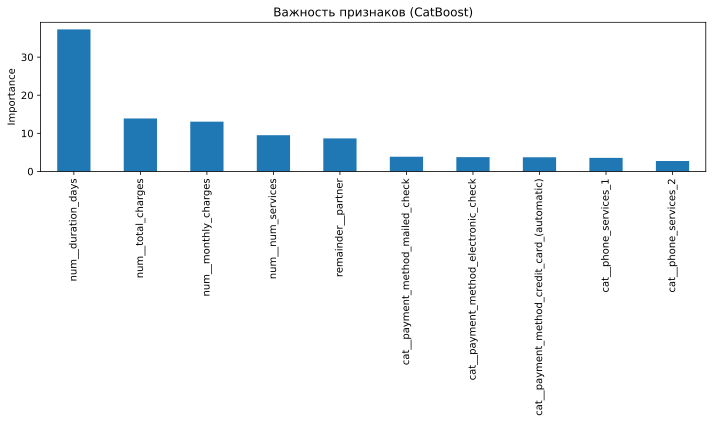

In [125]:
importances = catboost_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='bar')
plt.title('Важность признаков (CatBoost)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

Самые важные признаки для модели - это:

- продолжительность договора в днях
- помесячные расходы
- суммарные расходы
- количество оплачиваемых услуг
- наличие супруга/супруги

<h3>Confusion Matrix<a class="tocSkip"> </h3>

Матрица ошибок (confusion matrix) — это таблица, которая показывает, как хорошо модель классифицирует объекты.
Особенно полезна при дисбалансе классов (как у нас в задаче).

recall:  0.505
precision:  0.76
accuracy:  0.898


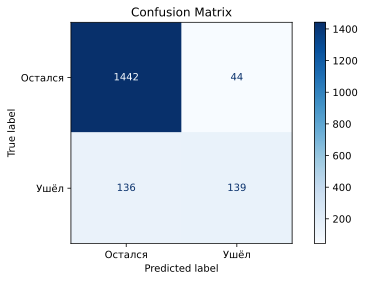

In [126]:
# Рассчитаем метрики

acc = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))
print('accuracy: ',round(acc,3))

# матрица ошибок 

cm = confusion_matrix(y_test, y_test_pred)

# Визуализация

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Остался", "Ушёл"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show();

TP — модель правильно предсказала уход клиента

TN — модель правильно предсказала, что клиент остался

FP — модель ошибочно предсказала уход (ложная тревога)

FN — модель не заметила уход (пропущенный уход)

У нашей модели низкий recall - полнота, то есть модель пропускает клиентов, которые ушли. Но вместе с тем, у модели хорошая точность (precision), то есть почти все случаи , когда клиенты, для которых модель предсказала уход, оказались верны. В зависимости от целей Заказчика, можно регулированием порога вероятности, достичь необходимой метрики recall либо precision.

<h3>ROC-кривая<a class="tocSkip"> </h3>

ROC-кривая — это способ визуально оценить, как хорошо модель отличает клиентов, которые уйдут, от тех, кто останется.

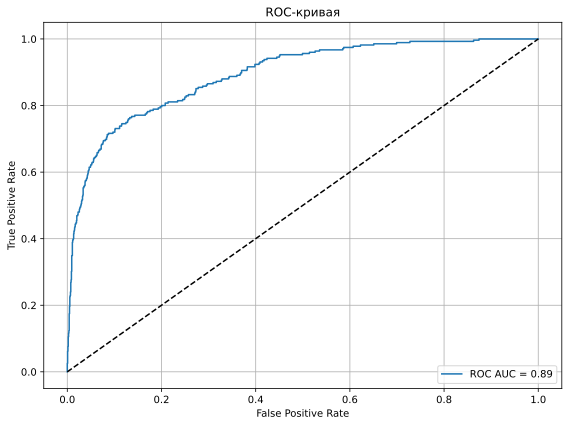

In [127]:
# ROC-кривая

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Визуализация

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

True Positive Rate (Recall) показывает, какую долю реально ушедших клиентов модель предсказала правильно.
Чем выше TPR, тем меньше пропущенных оттоков. 

False Positive Rate (Ложноположительная ошибка) показывает, какую долю клиентов, которые остались, модель ошибочно отнесла к уходящим.
Чем ниже FPR, тем меньше ложных тревог.

Чем ближе кривая находится к верхнему левому углу графика, тем лучше производительность модели.

По нашей кривой можно сказать, что при небольшом пороге модель находит уже бОльшую часть уходящих клиентов (график резко идет вверх)

In [128]:
# Найдём точку с максимальным Recall при разумном FPR

for i in range(len(thresholds)):
    print(f"Threshold: {thresholds[i]:.2f} | TPR (Recall): {tpr[i]:.2f} | FPR: {fpr[i]:.2f}")

Threshold: 1.99 | TPR (Recall): 0.00 | FPR: 0.00
Threshold: 0.99 | TPR (Recall): 0.00 | FPR: 0.00
Threshold: 0.95 | TPR (Recall): 0.03 | FPR: 0.00
Threshold: 0.94 | TPR (Recall): 0.03 | FPR: 0.00
Threshold: 0.92 | TPR (Recall): 0.06 | FPR: 0.00
Threshold: 0.92 | TPR (Recall): 0.06 | FPR: 0.00
Threshold: 0.91 | TPR (Recall): 0.08 | FPR: 0.00
Threshold: 0.90 | TPR (Recall): 0.08 | FPR: 0.00
Threshold: 0.87 | TPR (Recall): 0.11 | FPR: 0.00
Threshold: 0.87 | TPR (Recall): 0.11 | FPR: 0.00
Threshold: 0.87 | TPR (Recall): 0.12 | FPR: 0.00
Threshold: 0.86 | TPR (Recall): 0.12 | FPR: 0.00
Threshold: 0.86 | TPR (Recall): 0.12 | FPR: 0.00
Threshold: 0.85 | TPR (Recall): 0.12 | FPR: 0.00
Threshold: 0.82 | TPR (Recall): 0.17 | FPR: 0.00
Threshold: 0.82 | TPR (Recall): 0.17 | FPR: 0.00
Threshold: 0.81 | TPR (Recall): 0.20 | FPR: 0.00
Threshold: 0.81 | TPR (Recall): 0.20 | FPR: 0.01
Threshold: 0.78 | TPR (Recall): 0.23 | FPR: 0.01
Threshold: 0.78 | TPR (Recall): 0.23 | FPR: 0.01
Threshold: 0.78 | TP

[CV] END ....................models__C=1, models__penalty=l1; total time=   0.0s
[CV] END ...................models__C=10, models__penalty=l2; total time=   0.0s
[CV] END models__max_depth=None, models__min_samples_leaf=2, models__min_samples_split=5, models__n_estimators=50; total time=   0.2s
[CV] END models__max_depth=None, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=50; total time=   0.1s
[CV] END models__max_depth=None, models__min_samples_leaf=2, models__min_samples_split=5, models__n_estimators=100; total time=   0.2s
[CV] END models__depth=4, models__iterations=100, models__learning_rate=0.1; total time=   0.2s
[CV] END models__depth=10, models__iterations=300, models__learning_rate=0.1; total time=   1.5s
[CV] END ..................models__C=0.5, models__penalty=l2; total time=   0.0s
[CV] END ...................models__C=10, models__penalty=l1; total time=   0.0s
[CV] END ...................models__C=10, models__penalty=l2; total time=   0.0s

[CV] END ..................models__C=0.5, models__penalty=l1; total time=   0.0s
[CV] END ...................models__C=10, models__penalty=l1; total time=   0.0s
[CV] END ..................models__C=100, models__penalty=l1; total time=   0.0s
[CV] END models__max_depth=None, models__min_samples_leaf=2, models__min_samples_split=5, models__n_estimators=50; total time=   0.2s
[CV] END models__max_depth=None, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=50; total time=   0.1s
[CV] END models__max_depth=10, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=100; total time=   0.2s
[CV] END models__max_depth=20, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=100; total time=   0.2s
[CV] END models__criterion=entropy, models__max_depth=10, models__min_samples_leaf=2, models__min_samples_split=2; total time=   0.0s
[CV] END models__depth=6, models__iterations=200, models__learning_rate=0.01; total time=

[CV] END ..................models__C=0.5, models__penalty=l1; total time=   0.0s
[CV] END ....................models__C=1, models__penalty=l2; total time=   0.0s
[CV] END ..................models__C=100, models__penalty=l1; total time=   0.0s
[CV] END models__max_depth=None, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=50; total time=   0.1s
[CV] END models__max_depth=20, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=50; total time=   0.1s
[CV] END models__max_depth=10, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=100; total time=   0.2s
[CV] END models__criterion=entropy, models__max_depth=5, models__min_samples_leaf=4, models__min_samples_split=5; total time=   0.0s
[CV] END models__depth=4, models__iterations=100, models__learning_rate=0.1; total time=   0.2s
[CV] END models__depth=10, models__iterations=300, models__learning_rate=0.1; total time=   1.4s
[CV] END models__max_depth=20, m

Если бы мы захотели максимизировать Recall, чтобы не упустить клиентов, собирающихся "уходить", то оптимально порог вероятности модели можно было бы взять 0,3. При этом "ложных тревог"  было бы всего 6%.

##  Общий вывод и рекомендации для Заказчика

Была поставлена цель проекта — построить модель, предсказывающую вероятность оттока клиента (churn), чтобы компания могла вовремя принять меры и удерживать пользователей.

Компания столкнулась с проблемой, что часть клиентов перестаёт пользоваться услугами, но нет эффективного инструмента для прогнозирования таких случаев.
Наша задача — проанализировать данные, выявить закономерности и обучить надёжную модель, которая предсказывает отток с хорошим качеством. 

Данные представлены 4-мя csv-файлами:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии. 

**Ход проекта**

1. Загрузка, обзор данных, предобработка и объединение

- Загрузили 4 датасета: contract, personal, net, phone

- Привели имена столбцов и значения категорий к змеиному стилю (snake_case)

- Преобразовали даты (begin_date, end_date)

- Бинаризация признаков. Признаки со значениями `yes`/`no` приведены к 1/0 с автоматическим определением. Признак `gender` закодирован явно: `male` → 1, `female` → 0

- Обработка числовых данных. Признак `total_charges` преобразован в `float`, пропущенные значения `NaN` заменены соответствующими значениями из `monthly_charges`

- Проверена уникальность индексов внутри каждого датафрейма.

- Объединили таблицы по customerID в один датафрейм df. Пропуски в интернет-признаках (`online_security`, `tech_support`, `streaming_t_v`, и др.) заменены на заглушку -1 — интерпретируются как "услуга не подключена". Пропуски в телефонном признаке `multiple_lines` заменены также на -1 — интерпретируются как "не пользуются услугами телефонии". В столбце `internet_service` пропущенные значения заменены на `no_internet`, что означает "отсутствует интернет". 

- Создание целевого признака `churn`. Использована колонка `end_date`: NaT → клиент остался (churn = 0), дата → клиент ушёл (churn = 1).

2. Основные выводы исследовательского анализа. Портрет ушедшего клиента.

- Большинство клиентов компании с низким ежемесячным платежом. 
- В большинстве клиенты с небольшими общими расходами
- Ушедший клиент платил более высокие ежемесячные платежи. 
- По совокупным платежам ушли клиенты со средними общими расходами.
- Большинство имели долгосрочную подписку (1 год или 2 года)
- Доля ушедших клиентов с автосписаниями больше, чем с другими способами оплаты
- Больше уходит женатых/замужних клиентов.
- В основном среди ушедших больше тех, кто пользовался доп услугами: блокировкой опасных сайтов, облачным хранилищем, антивирусом и выделенной линией технической поддержки, сервисами ТВ и фильмов.
- среди ушедших больше тех, кто пользовался услугами второй линии сервиса телефонии

3. Создание новых признаков

- длительность договора в днях `duration_days`
- номер месяца заключения договора `begin_month`
- выделение сегментов: кто пользуется только интернетом, только телефонией и обеими типами услуг `service_segment`
- количество подключенных услуг `num_services`

4. Корреляционный анализ

По результатам анализа оставлены следующие признаки, которые хорошо коррелируют с нашей целевой переменной:
- `payment_method`
- `monthly_charges`
- `total_charges`
- `partner`
- `begin_month`
- `duration_days`
- `phone_services`
- `num_services`


4. Моделирование

Использовали Pipeline с ColumnTransformer (scale + one-hot)

Обучили и сравнили модели: LogisticRegression, RandomForest, DecisionTreeClassifier и CatBoostClassifier

Использовали RandomizedSearchCV для подбора гиперпараметров

Оценивали модели на тренировочной выборке по метрике ROC-AUC:

- CatBoostClassifier 0.963
- RandomForest 0.827
- DecisionTreeClassifier 0.782
- LogisticRegression 0.726

Лучшая модель CatBoostClassifier с мкетрикой ROC-AUC = 0.963

5. Тестирование

Метрика лучшей модели ROC-AUC на тесте: ≈ 0.85

6. Оценка важности признаков

Самые важные признаки для модели - это:
- продолжительность договора в днях
- месяц заключения договора
- суммарные расходы
- помесячные расходы
- количество оплачиваемых услуг
- наличие супруга/супруги

7. Матрица ошибок

Confusion Matrix показала, что модель лучше предсказывает тех, кто остаётся, чем тех, кто уходит. В зависимости от целей Заказчика, можно регулированием порога вероятности, достичь необходимой метрики recall либо precision.

8. ROC-кривая

Построена ROC-кривая. Выяснили, что при пороге вероятности 0.3 модель будет лучше прогнозировать уходящих клиентов (почти 67%), чтобы пропустить минимум, и не обременять спецпредложениями ошибочно тех, кто не собирался уходить (6%)

**Рекомендации для заказчика**

На основе анализа и модели можно дать следующие рекомендации:

Сфокусировать удержание на:

- Клиентах с коротким сроком договора, тех, кто воспользовался маркетинговыми предложениями на начальный период

- Пользователях с двумя и более услугами

- Клиентах с высокой ежемесячной платой

Разработать:

- Персональные предложения

- Скидки на подключение дополнительных услуг

- Повышение лояльности через акции и поддержку

Дополнить данные:

- Поведение клиента (жалобы, смена тарифа, обращение в поддержку)

- Геолокация, история платежей и т.д.